In [118]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt

dataset = pd.read_csv('Forex.csv')


In [119]:
dataset.head(5)

,Date,Open,High,Low,Close
0,2016-03-01,1240.49,1248.77,1227.48,1232.66
1,2016-03-02,1231.44,1244.23,1225.02,1239.83
2,2016-03-03,1239.49,1268.55,1237.72,1264.87
3,2016-03-04,1260.20,1279.97,1250.78,1261.55
4,2016-03-07,1264.23,1273.43,1257.12,1267.54


In [120]:
dataset.shape

(1451, 5)

In [121]:
num_train = int(dataset.shape[0]*0.7)
num_train

1015

In [122]:
training_set = dataset.iloc[0:num_train, 1].values
training_set.shape

(1015,)

In [123]:
training_set

array([1240.49, 1231.44, 1239.49, ..., 1593.43, 1577.24, 1552.94])

In [124]:
testing_set = dataset.iloc[num_train:, 1].values
testing_set.shape

(436,)

In [125]:
testing_set

array([1556.23 , 1566.85 , 1572.05 , 1572.19 , 1568.07 , 1566.04 ,
       1576.17 , 1582.4  , 1584.33 , 1601.68 , 1612.29 , 1620.57 ,
       1654.84 , 1659.35 , 1634.97 , 1640.81 , 1644.275, 1592.13 ,
       1587.07 , 1640.18 , 1639.46 , 1672.58 , 1698.35 , 1671.53 ,
       1653.22 , 1638.94 , 1577.09 , 1546.77 , 1508.19 , 1532.86 ,
       1485.   , 1467.94 , 1489.05 , 1564.79 , 1632.12 , 1611.37 ,
       1629.26 , 1620.75 , 1623.38 , 1576.59 , 1590.73 , 1615.89 ,
       1617.65 , 1663.92 , 1648.92 , 1645.8  , 1685.3  , 1711.84 ,
       1727.59 , 1717.84 , 1717.64 , 1682.59 , 1696.475, 1688.49 ,
       1713.94 , 1730.53 , 1728.52 , 1713.255, 1708.59 , 1714.05 ,
       1686.93 , 1701.92 , 1701.07 , 1706.04 , 1683.73 , 1717.12 ,
       1702.03 , 1697.26 , 1702.26 , 1716.515, 1730.43 , 1746.2  ,
       1732.54 , 1745.91 , 1747.92 , 1727.32 , 1733.7  , 1728.84 ,
       1710.75 , 1711.29 , 1719.05 , 1736.49 , 1738.97 , 1727.8  ,
       1700.42 , 1715.26 , 1684.24 , 1698.16 , 1713.9  , 1737.

In [126]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1,1))
testing_set_scaled = sc.fit_transform(testing_set.reshape(-1,1))


In [127]:
# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [128]:
X_train.shape

(955, 60)

In [129]:
X_train.shape[0]

955

In [130]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(955, 60, 1)

In [131]:
y_train.shape[0]

955

In [132]:
y_train = np.reshape(y_train, (y_train.shape[0],1))
y_train.shape

(955, 1)

In [133]:
X_test=[]
y_test =[]

In [134]:
for i in range(60, len(testing_set_scaled)):
    X_test.append(testing_set_scaled[i-60:i, 0])
    y_test.append(testing_set_scaled[i,0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [135]:
X_test.shape

(376, 60)

In [136]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test.shape

(376, 60, 1)

In [137]:
y_test = np.reshape(y_test, (y_test.shape[0],1))
y_test.shape

(376, 1)

In [139]:
import torch

In [140]:
# make training and test sets in torch
x_train = torch.from_numpy(X_train).type(torch.Tensor)
x_test = torch.from_numpy(X_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [142]:
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1

In [147]:
class LSTM(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = torch.nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
                # Readout layer
        self.fc = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)


LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [150]:
# Train model
#####################
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =60-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
                print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.06695938110351562
Epoch  20 MSE:  0.03850994259119034
Epoch  30 MSE:  0.02544942870736122
Epoch  40 MSE:  0.010428661480545998
Epoch  50 MSE:  0.004844225477427244
Epoch  60 MSE:  0.002770572667941451
Epoch  70 MSE:  0.002041325205937028
Epoch  80 MSE:  0.0016064794035628438
Epoch  90 MSE:  0.001377869863063097


In [ ]:
hist

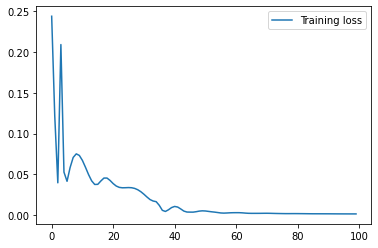

In [152]:
plt.plot(hist, label="Training loss")
plt.legend()
plt.show()

In [154]:
y_train_pred.shape

torch.Size([955, 1])

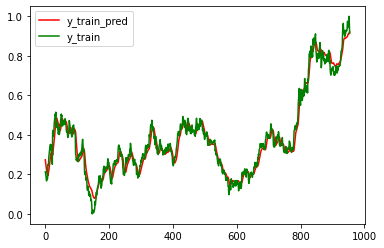

In [161]:
plt.plot(y_train_pred.detach().numpy(), label="y_train_pred", color='red')
plt.plot(y_train.detach().numpy(), label="y_train", color='green')
plt.legend()
plt.show()

In [175]:
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, r2_score

In [176]:
r2_score(y_train.detach().numpy(), y_train_pred.detach().numpy())

0.9702712777410883

In [164]:
y_test_pred = model(x_test)
y_test_pred.shape

torch.Size([376, 1])

In [177]:
r2_score(y_test.detach().numpy(), y_test_pred.detach().numpy())

0.8362999820751765

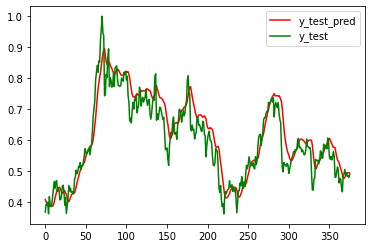

In [165]:
plt.plot(y_test_pred.detach().numpy(), label="y_test_pred", color='red')
plt.plot(y_test.detach().numpy(), label="y_test", color='green')
plt.legend()
plt.show()